## Get Borough data

In [36]:
import pandas as pd
import re

df = pd.read_csv('./places_analysis_results.csv')
# Define the boroughs and their regex patterns
boroughs = {
    "Manhattan": r"\b(Manhattan|M)\b",
    "Brooklyn": r"\b(Brooklyn|B)\b",
    "Queens": r"\b(Queens|Q)\b",
    "Bronx": r"\b(Bronx|BX)\b",
    "Staten Island": r"\b(Staten Island|SI)\b"
}

In [37]:
def find_borough(address):
    if isinstance(address, str):  # Check if the address is a string
        for borough, pattern in boroughs.items():
            if re.search(pattern, address, re.IGNORECASE):
                return borough
    return 'Not Found'

In [38]:
# Load your DataFrame (assuming it's already loaded as df)
# Ensure the address column exists
if "Address line 2"  in df.columns:
    # Apply the find_borough function to the "Full Address" column
    df["borough"] = df["Address line 2"].apply(find_borough)

    # Save the updated data
    df.to_csv("updated_addresses_with_boroughs.csv", index=False)
    print("Boroughs added and saved to updated_addresses_with_boroughs.csv")
else:
    print("Column 'Full Address' not found in the file.")

Boroughs added and saved to updated_addresses_with_boroughs.csv


In [39]:
if "borough" in df.columns:
    notFound= len(df[df["borough"] == "Not Found"])
    print(notFound)
else:
    print("Coloumn Borough not found")

4130


In [42]:
# Import necessary libraries
import pandas as pd

# Read the updated addresses CSV file
updated_addresses_df = pd.read_csv('./updated_addresses_with_boroughs.csv')

# Display the first few rows to understand the structure
print("First few rows of the updated addresses data:")
print(updated_addresses_df.head())

# Function to determine borough based on latitude and longitude
def get_borough(lat, lon):
    # Placeholder for actual logic to determine borough
    # This could be a lookup or a call to an external API
    return "Determined Borough"  # Replace with actual logic

# Apply changes only on rows where 'Borough' is 'Not Found'
mask = updated_addresses_df['borough'] == 'Not Found'
updated_addresses_df.loc[mask, 'borough'] = updated_addresses_df.loc[mask].apply(
    lambda row: get_borough(row['Latitude'], row['Longitude']), axis=1
)

# Display the updated DataFrame
print("\nUpdated borough details:")
print(updated_addresses_df["borough"].value_counts())

First few rows of the updated addresses data:
                       Address line 1              Address line 2  \
0          217 W 57th St Unit 127/128         Manhattan, NY 10019   
1  764 Saint Nicholas /C2 Ave Unit C1          New York, NY 10031   
2                        34 W 89th St         Manhattan, NY 10024   
3                     177 Benedict Rd     Staten Island, NY 10304   
4                     115-30 116th St  South Ozone Park, NY 11420   

                                        Full Address   Latitude  Longitude  \
0    217 W 57th St Unit 127/128 Manhattan, NY 10019   40.766474 -73.981266   
1  764 Saint Nicholas /C2 Ave Unit C1 New York, N...  40.826130 -73.943006   
2                  34 W 89th St Manhattan, NY 10024   40.787587 -73.969240   
3           177 Benedict Rd Staten Island, NY 10304   40.595008 -74.106434   
4        115-30 116th St South Ozone Park, NY 11420   40.675746 -73.822413   

   Number_of_Parks_Nearby  Distance_to_Nearest_Parks_miles  \
0       

In [47]:
import time
import pandas as pd
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Load your dataset
df = pd.read_csv("./updated_addresses_with_boroughs.csv")

# Initialize the geolocator
geolocator = Nominatim(user_agent="geo_borough_finder")

# Progress tracking file
progress_file = "progress.json"

# Load progress if available
try:
    with open(progress_file, "r") as f:
        progress = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    progress = {}

def get_borough(lat, lon):
    try:
        lat, lon = float(lat), float(lon)
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location and 'address' in location.raw:
            address = location.raw['address']
            time.sleep(1)  # Avoid rate limits
            return address.get('borough', address.get('city', 'Unknown'))
    except ValueError:
        return "Invalid Coordinates"
    except GeocoderTimedOut:
        return "Timeout"
    return "Not Found"

# Ensure latitude and longitude are valid
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

batch_size = 10  # Adjust based on rate limits
updated_rows = []
for index, row in df.iterrows():
    if row['borough'] == "Not Found":
        lat, lon = row['Latitude'], row['Longitude']
        key = f"{lat},{lon}"
        
        if key in progress:
            borough = progress[key]  # Use cached result
        else:
            borough = get_borough(lat, lon)
            progress[key] = borough
        
        df.at[index, 'borough'] = borough
        updated_rows.append(row)
        
        if index % batch_size == 0:
            with open(progress_file, "w") as f:
                json.dump(progress, f)
            df.to_csv("updated_data.csv", index=False)

# Save the updated DataFrame
updated_df = pd.DataFrame(updated_rows)
updated_df.to_csv("newly_updated_values.csv", index=False)  # Save only newly updated values
df.to_csv("updated_data.csv", index=False)  # Save full updated dataset
with open(progress_file, "w") as f:
    json.dump(progress, f)

print("Updated boroughs saved to updated_data.csv")
print("Newly updated values saved to newly_updated_values.csv")


Updated boroughs saved to updated_data.csv
Newly updated values saved to newly_updated_values.csv


borough
Manhattan        3854
Brooklyn         2815
Queens           2054
Staten Island    1198
Bronx            1164
Name: count, dtype: int64


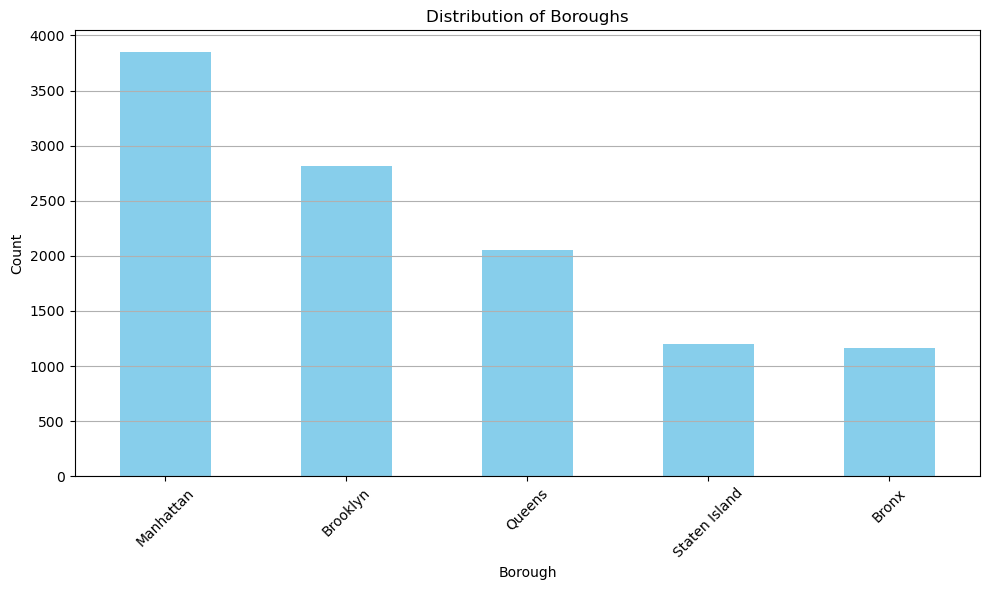

In [49]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the updated addresses CSV file
updated_addresses_df = pd.read_csv('./updated_data.csv')

# Display the first few rows to understand the structure
print(updated_addresses_df['borough'].value_counts())
updated_addresses_df['borough'] = updated_addresses_df['borough'].replace('The Bronx', 'Bronx')

values_to_remove = [
    "Invalid Coordinates",
    "Unknown",
    "City of Rochester",
    "City of Niagara Falls",
    "City of Yonkers"
]

# Remove rows with specified values in the Borough column
updated_addresses_df = updated_addresses_df[~updated_addresses_df['borough'].isin(values_to_remove)]

# Plotting the histogram of boroughs
plt.figure(figsize=(10, 6))
updated_addresses_df['borough'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

updated_addresses_df.to_csv('./updated_data.csv', index=False)

# Random Forest Eval

### consolidating the Final dataset

In [ ]:
import pandas as pd
# Check how many rows have the same value in the 'Address Line 1' and 'Address Line 2' attributes in both updated_data.csv and realtor 11k.csv
realtor_df = pd.read_csv('./data/realtor 11k.csv')
places_df = pd.read_csv('updated_data.csv')

# Check how many rows have the same value in the 'Address Line 1' attribute
same_values_address_line_1 = realtor_df["Address line 1"].isin(places_df["Address line 1"]).sum()
print(f"There are {same_values_address_line_1} rows with the same 'Address Line 1' value in both dataframes.")

# Check how many rows have the same value in the 'Address Line 2' attribute
same_values_address_line_2 = realtor_df["Address line 2"].isin(places_df["Address line 2"]).sum()
print(f"There are {same_values_address_line_2} rows with the same 'Address Line 2' value in both dataframes.")
# Merge the two datasets based on 'Address Line 1' and 'Address Line 2'
merged_df = pd.merge(realtor_df, places_df, on=['Address line 1', 'Address line 2','Full Address'], how='inner')

# Check for duplicate columns and store one
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Display the attributes of the dataframe
print(merged_df.columns)

# Store the final datasource in a csv named "final_data.csv"
merged_df.to_csv('./final_data.csv', index=False)

print("Realtor lenght: ",len(realtor_df))
print("Places lenght: ",len(places_df))

There are 11086 rows with the same 'Address Line 1' value in both dataframes.
There are 11086 rows with the same 'Address Line 2' value in both dataframes.
Index(['Property Link', 'Type of House', 'Property Value', 'bed', 'bath',
       '\r\nbed', 'Area (Sqft)', 'Address line 1', 'Address line 2',
       'Full Address_x',
       'PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0',
       'lot size', 'appreciate/depreciate', 'Full Address_y', 'Latitude',
       'Longitude', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', '

In [42]:
# Display the categorical and numerical attributes in the dataframe
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

print("Categorical attributes: ", categorical_columns)
print("Numerical attributes: ", numerical_columns)



Categorical attributes:  Index(['Property Link', 'Type of House', 'Property Value', 'bed', 'bath',
       'Area (Sqft)', 'Address line 1', 'Address line 2', 'Full Address_x',
       'Property lot size', 'lot size', 'appreciate/depreciate',
       'Full Address_y', 'borough'],
      dtype='object')
Numerical attributes:  Index(['\r\nbed', 'Latitude', 'Longitude', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby',
       'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby',
       'Distance_to_Nearest

C:\Users\admin\AppData\Local\Temp\ipykernel_14524\1554622853.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./final_data.csv')
C:\Users\admin\AppData\Local\Temp\ipykernel_14524\1554622853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Property lot size'] = filtered_data['Property lot size'].astype(str)


Type of values in 'Property lot size':  [nan 'sqft lot' 'acre lot']


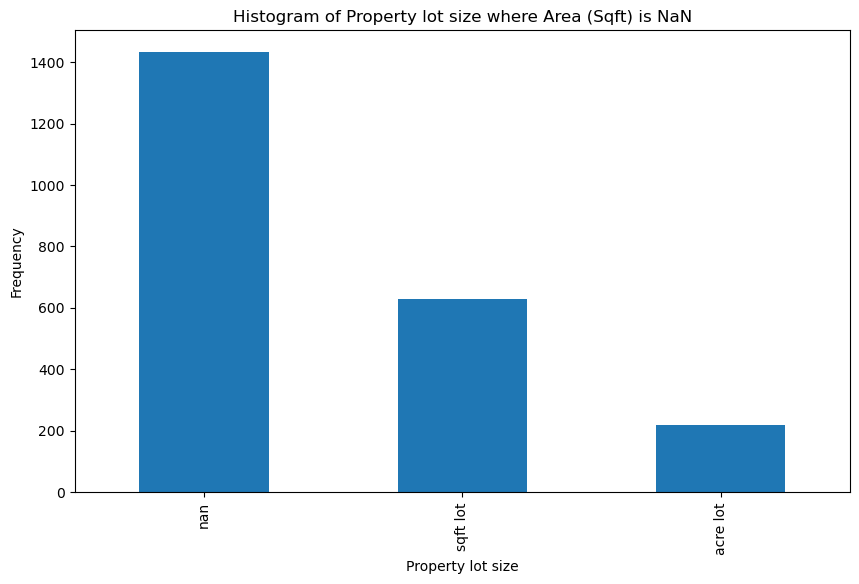

In [68]:
data = pd.read_csv('./final_data.csv')
data = data.drop_duplicates(subset='Property Link')


import matplotlib.pyplot as plt

# Filter the dataframe where 'Area (Sqft)' is NaN
filtered_data = data[data['Area (Sqft)'].isna()]

# Display the type of values in 'Property lot size'
print("Type of values in 'Property lot size': ", filtered_data['Property lot size'].unique())

# Convert 'Property lot size' to string to include NaN values in the histogram
filtered_data['Property lot size'] = filtered_data['Property lot size'].astype(str)

# Plot a histogram for 'Property lot size'
plt.figure(figsize=(10,6))
filtered_data['Property lot size'].value_counts().plot(kind='bar')
plt.title('Histogram of Property lot size where Area (Sqft) is NaN')
plt.xlabel('Property lot size')
plt.ylabel('Frequency')
plt.show()





In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the dataset
data = pd.read_csv('./final_data.csv')

# Check for attributes which contain NaN value and display the column names
data = data.drop_duplicates(subset='Property Link')

nan_columns = data.isna().any()
print("Columns with NaN values:")
print(nan_columns[nan_columns == True].index)


data.loc[data['bed'] == 'Studio', 'bed'] = 0

data['lot size'] = pd.to_numeric(data['lot size'], errors='coerce')

# Convert 'Property lot size' from acre to sqft if 'Property lot size' is 'acre lot'
data.loc[data['Property lot size'] == 'acre lot', 'lot size'] = data['lot size'] * 43560
data.loc[data['Property lot size'] == 'acre lot', 'Property lot size'] = 'sqft lot'
# Validate the conversion by checking the 'Property lot size' and 'lot size' values
print(data[data['Property lot size'] == 'sqft lot'][['Property lot size', 'lot size']])

# Check for NaN values
print("NaN values in 'lot size':", data['lot size'].isna().sum())

data['Property Value'] = data['Property Value'].str.replace('$', '').str.replace(',', '')
data['Property Value'] = pd.to_numeric(data['Property Value'], errors='coerce')
data['lot size'] = pd.to_numeric(data['lot size'],errors='coerce')
data['Area (Sqft)'] = pd.to_numeric(data['Area (Sqft)'],errors='coerce')


data = data[data['Property Value'].notna()]
# print(data)

data.to_csv('./untill-now.csv')

C:\Users\admin\AppData\Local\Temp\ipykernel_14524\1632803963.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./final_data.csv')


Columns with NaN values:
Index(['Property Link', 'bed', 'bath', '\r\nbed', 'Area (Sqft)',
       'Full Address_x', 'Property lot size', 'lot size',
       'appreciate/depreciate'],
      dtype='object')
      Property lot size  lot size
3              sqft lot   68824.8
4              sqft lot       NaN
9              sqft lot       NaN
11             sqft lot       NaN
12             sqft lot     791.0
...                 ...       ...
16602          sqft lot       NaN
16604          sqft lot   30927.6
16607          sqft lot   20908.8
16608          sqft lot       NaN
16609          sqft lot       NaN

[3715 rows x 2 columns]
NaN values in 'lot size': 7789


In [ ]:
# Define the categorical and numerical columns
categorical_columns=['borough','Type of House','bed', 'bath']
numerical_columns = ['Area (Sqft)','lot size', 'Number_of_Parks_Nearby',
       'Distance_to_Nearest_Parks_miles', 'Number_of_Malls_Nearby',
       'Distance_to_Nearest_Malls_miles', 'Number_of_Metros_Nearby',
       'Distance_to_Nearest_Metros_miles', 'Number_of_Clubs_Nearby',
       'Distance_to_Nearest_Clubs_miles', 'Number_of_Restaurants_Nearby',
       'Distance_to_Nearest_Restaurants_miles', 'Number_of_Schools_Nearby',
       'Distance_to_Nearest_Schools_miles', 'Number_of_Colleges_Nearby',
       'Distance_to_Nearest_Colleges_miles', 'Number_of_Universities_Nearby',
       'Distance_to_Nearest_Universities_miles', 'Number_of_Buses_Nearby',
       'Distance_to_Nearest_Buses_miles', 'Number_of_Trains_Nearby',
       'Distance_to_Nearest_Trains_miles', 'Number_of_Airports_Nearby',
       'Distance_to_Nearest_Airports_miles', 'Number_of_Museums_Nearby',
       'Distance_to_Nearest_Museums_miles', 'Number_of_Libraries_Nearby',
       'Distance_to_Nearest_Libraries_miles',
       'Number_of_Grocery_stores_Nearby',
       'Distance_to_Nearest_Grocery_stores_miles']

# One-hot encode the categorical columns
data = pd.get_dummies(data, columns=categorical_columns)

# Define the features and target
X = data.drop('Property Value', axis=1)
y = data['Property Value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train data:",X_train.dtypes)
# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

# Feature importance
feature_importances = rf.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=X.columns, y=feature_importances)
plt.title('Feature Importances')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist

def calculate_nyc_safety_score(real_estate_df, crime_df, zip_code_mapping=None):
    """
    Calculate safety scores for NYC neighborhoods using real estate and crime data.
    
    Parameters:
    -----------
    real_estate_df : DataFrame
        Contains property data with columns:
        - property_id: Unique identifier for each property
        - zipcode or neighborhood: Location identifier
        - latitude, longitude: Coordinates
        - Various amenities columns (police_station, fire_station, hospital, etc.)
        
    crime_df : DataFrame
        Contains crime data with columns:
        - incident_id: Unique identifier for each crime incident
        - zipcode or neighborhood: Location identifier
        - latitude, longitude: Coordinates
        - crime_type: Category of crime
        - severity: Numerical severity rating
        - date: Date of incident
        
    zip_code_mapping : DataFrame, optional
        Mapping between zip codes and neighborhoods if needed
    
    Returns:
    --------
    DataFrame
        Original real_estate_df with additional safety_score column
    """
    # 1. Standardize location identifiers (zip code or neighborhood)
    if zip_code_mapping is not None:
        # Map zip codes to neighborhoods if necessary
        real_estate_df = pd.merge(real_estate_df, zip_code_mapping, on='zipcode', how='left')
        crime_df = pd.merge(crime_df, zip_code_mapping, on='zipcode', how='left')
    
    # 2. Process crime data
    # Calculate crime density and severity by neighborhood
    crime_stats = calculate_crime_metrics(crime_df)
    
    # 3. Process amenities data
    amenities_score = calculate_amenities_score(real_estate_df)
    
    # 4. Combine scores
    result_df = real_estate_df.copy()
    result_df = pd.merge(result_df, crime_stats, on='neighborhood', how='left')
    result_df = pd.merge(result_df, amenities_score, on='property_id', how='left')
    
    # 5. Calculate final safety score
    result_df['safety_score'] = calculate_final_score(result_df)
    
    return result_df

def calculate_crime_metrics(crime_df):
    """
    Calculate crime density and severity metrics by neighborhood.
    
    Returns DataFrame with columns:
    - neighborhood
    - crime_density_score
    - crime_severity_score
    - crime_trend_score
    """
    # Set weights for different crime types based on severity
    crime_weights = {
        'FELONY': 1.0,
        'MISDEMEANOR': 0.5,
        'VIOLATION': 0.25
    }
    
    # Apply weights to crime types
    crime_df['weighted_severity'] = crime_df['crime_type'].map(crime_weights)
    
    # Calculate crime metrics per neighborhood
    crime_stats = crime_df.groupby('neighborhood').agg(
        crime_count=('incident_id', 'count'),
        avg_severity=('weighted_severity', 'mean'),
    ).reset_index()
    
    # Add time trend analysis if dates are available
    if 'date' in crime_df.columns:
        # Get the last 3 months of data
        crime_df['date'] = pd.to_datetime(crime_df['date'])
        recent_cutoff = crime_df['date'].max() - pd.Timedelta(days=90)
        recent_crimes = crime_df[crime_df['date'] >= recent_cutoff]
        
        # Calculate recent crime stats
        recent_stats = recent_crimes.groupby('neighborhood').agg(
            recent_crime_count=('incident_id', 'count')
        ).reset_index()
        
        crime_stats = pd.merge(crime_stats, recent_stats, on='neighborhood', how='left')
        crime_stats['recent_crime_count'] = crime_stats['recent_crime_count'].fillna(0)
        
        # Calculate trend (normalized by total crime count to avoid neighborhood size bias)
        total_period = (crime_df['date'].max() - crime_df['date'].min()).days / 30  # in months
        crime_stats['monthly_avg'] = crime_stats['crime_count'] / total_period
        crime_stats['crime_trend'] = (crime_stats['recent_crime_count'] / 3) - crime_stats['monthly_avg']
        
    # Normalize scores (higher crime = lower safety score)
    scaler = MinMaxScaler()
    
    # Invert so higher crime = lower score
    crime_stats['crime_density_score'] = 1 - scaler.fit_transform(crime_stats[['crime_count']])
    crime_stats['crime_severity_score'] = 1 - scaler.fit_transform(crime_stats[['avg_severity']])
    
    if 'crime_trend' in crime_stats.columns:
        min_trend = crime_stats['crime_trend'].min()
        max_trend = crime_stats['crime_trend'].max()
        range_trend = max_trend - min_trend
        
        # Normalize trend (declining crime = higher safety score)
        crime_stats['crime_trend_score'] = 1 - ((crime_stats['crime_trend'] - min_trend) / range_trend)
    
    return crime_stats

def calculate_amenities_score(real_estate_df):
    """
    Calculate amenities-based safety score.
    
    Returns DataFrame with columns:
    - property_id
    - amenities_safety_score
    """
    # Define safety-enhancing amenities and their weights
    safety_amenities = {
        'police_station': 0.25,
        'fire_station': 0.20,
        'hospital': 0.15,
        'pharmacy': 0.10,
        'street_light_density': 0.10,
        'security_camera': 0.10,
        'subway_station': 0.05,
        'bus_stop': 0.05
    }
    
    # Initialize the amenities score
    amenities_score_df = pd.DataFrame({'property_id': real_estate_df['property_id']})
    amenities_score_df['amenities_safety_score'] = 0
    
    # Calculate distance-based scores for point amenities
    for amenity, weight in safety_amenities.items():
        if amenity in real_estate_df.columns:
            if amenity in ['street_light_density', 'security_camera']:
                # Direct values - higher is better
                if real_estate_df[amenity].max() > 0:
                    scaler = MinMaxScaler()
                    normalized = scaler.fit_transform(real_estate_df[[amenity]])
                    amenities_score_df['amenities_safety_score'] += normalized.flatten() * weight
            else:
                # Distance values - closer is better (assume these are boolean indicators of presence)
                amenities_score_df['amenities_safety_score'] += real_estate_df[amenity].astype(float) * weight
    
    # Scale the final amenities score to be between 0 and 1
    if amenities_score_df['amenities_safety_score'].max() > 0:
        scaler = MinMaxScaler()
        amenities_score_df['amenities_safety_score'] = scaler.fit_transform(
            amenities_score_df[['amenities_safety_score']]
        )
    
    return amenities_score_df

def calculate_final_score(df):
    """
    Calculate the final safety score using weighted components.
    """
    # Define component weights
    weights = {
        'crime_density': 0.4,
        'crime_severity': 0.3,
        'crime_trend': 0.1,
        'amenities': 0.2
    }
    
    # Initialize base score
    safety_score = np.zeros(len(df))
    
    # Add crime density component
    if 'crime_density_score' in df.columns:
        safety_score += df['crime_density_score'].fillna(0.5) * weights['crime_density']
    
    # Add crime severity component
    if 'crime_severity_score' in df.columns:
        safety_score += df['crime_severity_score'].fillna(0.5) * weights['crime_severity']
    
    # Add crime trend component
    if 'crime_trend_score' in df.columns:
        safety_score += df['crime_trend_score'].fillna(0.5) * weights['crime_trend']
    
    # Add amenities component
    if 'amenities_safety_score' in df.columns:
        safety_score += df['amenities_safety_score'].fillna(0) * weights['amenities']
    
    # Scale to 0-100 range
    return safety_score * 100

def visualize_safety_scores(df, neighborhood_boundaries=None):
    """
    Visualize safety scores on a map.
    Requires geopandas and matplotlib.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with safety scores and coordinates
    neighborhood_boundaries : GeoDataFrame, optional
        GeoDataFrame with neighborhood boundaries
    """
    try:
        import geopandas as gpd
        import matplotlib.pyplot as plt
        from matplotlib.colors import LinearSegmentedColormap
        
        # Create custom colormap (red to green)
        colors = [(0.8, 0, 0), (1, 1, 0), (0, 0.8, 0)]
        cmap = LinearSegmentedColormap.from_list('safety_cmap', colors, N=100)
        
        # Set up the plot
        fig, ax = plt.subplots(1, figsize=(12, 10))
        
        # Plot neighborhood boundaries if available
        if neighborhood_boundaries is not None:
            neighborhood_boundaries.plot(ax=ax, color='lightgrey', alpha=0.5)
        
        # Create points from coordinates
        gdf = gpd.GeoDataFrame(
            df, 
            geometry=gpd.points_from_xy(df.longitude, df.latitude)
        )
        
        # Plot safety scores
        gdf.plot(
            ax=ax,
            column='safety_score',
            cmap=cmap,
            legend=True,
            markersize=5,
            alpha=0.7,
            legend_kwds={'label': 'Safety Score', 'orientation': 'horizontal'}
        )
        
        # Add title and axis labels
        plt.title('NYC Neighborhood Safety Scores', fontsize=15)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Visualization requires geopandas and matplotlib. Please install them first.")